# TFRecord Practice

Tensorflow provides serialization through [protocol buffer(protobuf)](https://developers.google.com/protocol-buffers/). Protocol buffers are Google's language-neutral, platform-neutral, extensible mechanism for serializing structured data – think XML, but smaller, faster, and simpler. You define how you want your data to be structured once, then you can use special generated source code to easily write and read your structured data to and from a variety of data streams and using a variety of languages.

Python already provide serialization through pickle module, however, most of tensorflow implemented based on protobuf. For example, graphdef, operations, etc are structured through protobuf.

Tensorflow provides Example and Feature protobuf type. In this practice, we will convert data to Example and Feature type(tfrecord) and read and write that converted data.

In [1]:
import os
import tensorflow as tf
import numpy as np

In [2]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [3]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [4]:
# images and labels array as input
# labels for supervised setting
def convert_to(images, name, labels=None):
    num_examples = images.shape[0]
    if labels is not None:
        if labels.shape[0] != num_examples:
            raise ValueError("Images size %d does not match label size %d." %
                             (images.shape[0], num_examples))
    height = images.shape[1]
    width = images.shape[2]
    channels = images.shape[3]

    filename = os.path.join(name + '.tfrecords')
    print('Writing', filename)
    writer = tf.python_io.TFRecordWriter(filename)
    for index in range(num_examples):
        image_raw = images[index].tostring()
        if labels is not None:
            example = tf.train.Example(features=tf.train.Features(feature={
                'height': _int64_feature(height),
                'width': _int64_feature(width),
                'label': _int64_feature(int(labels[index])),
                'data': _bytes_feature(image_raw)}))
        else:
            example = tf.train.Example(features=tf.train.Features(feature={
                'height': _int64_feature(height),
                'width': _int64_feature(width),
                'data': _bytes_feature(image_raw)}))
        writer.write(example.SerializeToString())
    writer.close()

Let's convert 100 randomly selected COCO images to tfrecords.

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

In [6]:
data_dir = 'data/COCO_samples'
images=np.asarray([np.asarray(Image.open(os.path.join(data_dir,i)).resize([224,224],Image.ANTIALIAS))
            for i in os.listdir(data_dir) if i.endswith('.jpg')])

(100, 224, 224, 3)


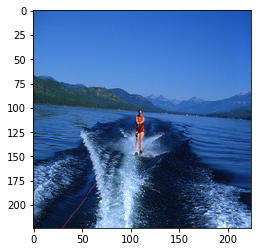

In [7]:
plt.imshow(images[11])
print(images.shape)

In [8]:
convert_to(images,'data/COCO_samples')

Writing data/COCO_samples.tfrecords


In [9]:
# reload serialized images
record_iterator = tf.python_io.tf_record_iterator(path='data/COCO_samples.tfrecords')
count = 0
images_reloaded = []
for string_record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height'].int64_list.value[0])
    width = int(example.features.feature['width'].int64_list.value[0])
    data = (example.features.feature['data'].bytes_list.value[0])
    images_reloaded.append(np.fromstring(data,dtype=np.uint8).reshape((height,width,-1)))

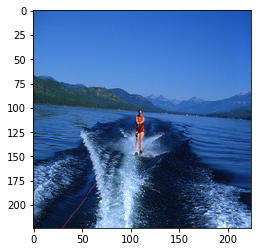

In [10]:
plt.imshow(images_reloaded[11])

In [11]:
# Remember to generate a file name queue of you 'train.TFRecord' file path
def read_and_decode(filename_queue, read_labels = False):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    
    if read_labels:
        features = tf.parse_single_example(
            serialized_example,
            features={'height':tf.FixedLenFeature([],tf.int64),
                      'width':tf.FixedLenFeature([],tf.int64),
                      'data':tf.FixedLenFeature([],tf.string),
                      'label':tf.FixedLenFeature([],tf.int64)})
    else:
        features = tf.parse_single_example(
            serialized_example,
            features={'height':tf.FixedLenFeature([],tf.int64),
                      'width':tf.FixedLenFeature([],tf.int64),
                      'data':tf.FixedLenFeature([],tf.string)})
    
    # Convert from a scalar string tensor (whose single string has
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)

    image = tf.decode_raw(features['data'], tf.uint8)

    # reshape
    image_shape = (224,224,3)
    image = tf.reshape(image, image_shape)
    
#     # Convert from [0, 255] -> [-0.5, 0.5] floats.
#     image = tf.cast(image, tf.float32)
#     image = tf.cast(image, tf.float32) * (1. / 255) - 0.5
    
    # or add mean value of the image, flip-flop, crop ... you can do any transformation here.

    if read_labels:
        # Convert label from a scalar uint8 tensor to an int32 scalar.
        label = tf.cast(features['label'], tf.int32)
        images, labels = tf.train.shuffle_batch([image, label],batch_size=2, capacity=30, num_threads=4, min_after_dequeue=10)
        return images, labels
    else:
        images = tf.train.shuffle_batch([image],batch_size=2, capacity=30, num_threads=4, min_after_dequeue=10)
        return images    

current batch shape:  (2, 224, 224, 3)
current batch shape:  (2, 224, 224, 3)
current batch shape:  (2, 224, 224, 3)
current batch shape:  (2, 224, 224, 3)
current batch shape:  (2, 224, 224, 3)


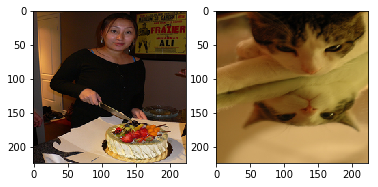

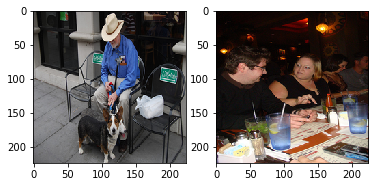

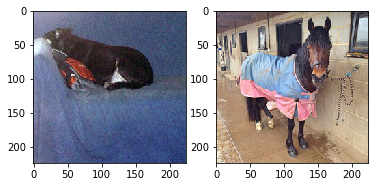

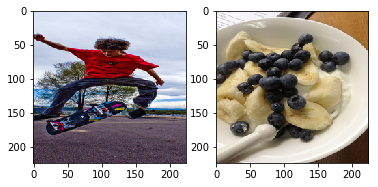

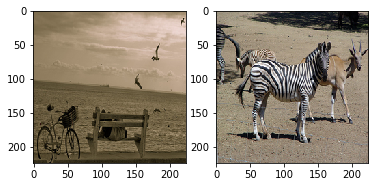

In [12]:
filename_queue = tf.train.string_input_producer(['data/COCO_samples.tfrecords'],num_epochs=5)
image = read_and_decode(filename_queue)
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

with tf.Session() as sess:
    sess.run(init_op)
    # coordinator starts queue we made before
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # just 5 batches for example.
    for i in range(5):
        img = sess.run(image)
        print('current batch shape: ',img.shape)
        fig,ax = plt.subplots(1,2)
        ax[0].imshow(img[0])
        ax[1].imshow(img[1])
    
    coord.request_stop()
    coord.join(threads)